## Machine Learning Notebook

We will use this notebook to do a quick data exploration and model selection for our pipeline.

## Part 1: Data Retrieval

In the model training pipeline, `src/connect_api.py` and `src/get_features.py` have been used to retrieve the training data.
1. Query for transaction of the house via Singapore government's official data.gov.sg: https://guide.data.gov.sg/developers/api-v2 
2. Query for location of the house via Onemap API: https://www.onemap.gov.sg/apidocs/
3. Utilize geopy to calculate distance to the nearest train (MRT) station.
4. Relevant have then been filtered out accordingly.

In the code section below, we extract out `processed` data for our model work. 

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re

# For model training (classification)
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# For regression
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance


In [65]:
df = pd.read_json('data/2024_pipe/data_features.json', lines= True)
df = df.sample(frac=1)  # To use all data, put frac = 1
df.columns

Index(['distance_mrt', 'town', 'area', 'flat_num', 'age_transation',
       'lease_commence', 'transaction_yr', 'transaction', 'storey_height',
       'resale_price', 'resale_price_adj', 'Postal', 'Location'],
      dtype='object')

In [66]:
# Data preprocessing to select out the relevant columns

columns = ['distance_mrt','age_transation','transaction_yr','Postal','storey_height', 'resale_price_adj','town','flat_num']

df_chosen = df[columns].copy()
df_chosen = df_chosen[df_chosen['Postal']!='NIL']  #remove the items with no postal code#
df_chosen['Postal'] = df_chosen['Postal'].astype(int)  #convert to int

print(df_chosen.shape[0], 'filtered out of:', df.shape[0])

169575 filtered out of: 169584


In [67]:
# Create train and test sets
model_data = df_chosen.copy()

X = model_data.drop('resale_price_adj', axis=1)
y = model_data['resale_price_adj']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=573)

In [68]:
X_train.head()

,distance_mrt,age_transation,transaction_yr,Postal,storey_height,town,flat_num
111288,1.249196,7,2021,523520,3,TAMPINES,3 ROOM
142458,0.750880,10,2022,132028,2,QUEENSTOWN,3 ROOM
65853,1.407960,39,2020,730206,3,WOODLANDS,3 ROOM
162028,1.233430,5,2023,822233,6,PUNGGOL,5 ROOM
93934,0.331070,19,2021,211672,1,CENTRAL AREA,5 ROOM


As you can see, we have numeric features that needs to be normalized before model training. We also have categorical features that need to go through one-hot encoding before model optimization.

## Part 2: Model Training

In [69]:
# Create training/ testing pipelines
numeric_features = ['distance_mrt', 'age_transation',
       'transaction_yr', 'Postal',
       'storey_height']
categorical_features = ['town', 'flat_num']

numeric_transformer = StandardScaler()
categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
)

preprocess = make_column_transformer(
    (numeric_transformer, numeric_features),  
    (categorical_transformer, categorical_features)
)

In [70]:
# Credit for function adapted from UBC's MDS course: DSCI571

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    print(out_col)
    return pd.Series(data=out_col, index=mean_scores.index)

In [71]:
# We will evaluate a set of models for this project
regressor_models = {
    "Dummy Regressor": DummyRegressor(), 
    "KNN Regressor": KNeighborsRegressor(),
    "Ridge": Ridge(random_state=1),
    "RFR": RandomForestRegressor(random_state=1, n_estimators=10), 
    "GB": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

cv_results_reg = {}
scoring_metrics = ['r2', 'neg_mean_absolute_error']

for model_name, model in regressor_models.items():
    pipe = make_pipeline(preprocess, model)
    cv_results_reg[model_name] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True, n_jobs=-1, scoring=scoring_metrics)
    print("Done with", model_name)

results_df_reg = pd.DataFrame(cv_results_reg).T

# Calculating the adjusted R2: 
X_sample = preprocess.fit_transform(X_train)
p = X_sample.shape[1]
n = X_sample.shape[0]

results_df_reg['test_r2_num'] = results_df_reg['test_r2'].apply(lambda x: float(re.search(r'\d+\.\d+', x).group()) if re.search(r'\d+\.\d+', x) else None)
results_df_reg['test_adj_r2'] = 1 - ((1 - results_df_reg['test_r2_num']) * (n - 1) / (n - p - 1))
results_df_reg.drop(columns=['test_r2_num'], inplace=True)

results_df_reg


['0.077 (+/- 0.034)', '0.017 (+/- 0.011)', '-0.000 (+/- 0.000)', '0.000 (+/- 0.000)', '-113495.843 (+/- 270.251)', '-113495.490 (+/- 61.269)']
Done with Dummy Regressor
['0.065 (+/- 0.002)', '8.752 (+/- 0.022)', '0.937 (+/- 0.002)', '0.959 (+/- 0.000)', '-25137.780 (+/- 252.463)', '-20177.452 (+/- 67.989)']
Done with KNN Regressor
['0.105 (+/- 0.007)', '0.015 (+/- 0.002)', '0.836 (+/- 0.003)', '0.836 (+/- 0.001)', '-44616.154 (+/- 230.941)', '-44597.761 (+/- 72.433)']
Done with Ridge
['6.291 (+/- 0.029)', '0.091 (+/- 0.002)', '0.960 (+/- 0.001)', '0.991 (+/- 0.000)', '-20484.158 (+/- 111.277)', '-9228.692 (+/- 26.011)']
Done with RFR
['16.726 (+/- 0.087)', '0.056 (+/- 0.006)', '0.886 (+/- 0.002)', '0.887 (+/- 0.001)', '-35126.667 (+/- 320.957)', '-35003.213 (+/- 98.591)']
Done with GB
['1.206 (+/- 0.019)', '0.071 (+/- 0.001)', '0.952 (+/- 0.001)', '0.958 (+/- 0.001)', '-22847.273 (+/- 280.014)', '-21762.174 (+/- 121.537)']
Done with XGBoost


,fit_time,score_time,test_r2,train_r2,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_adj_r2
Dummy Regressor,0.077 (+/- 0.034),0.017 (+/- 0.011),-0.000 (+/- 0.000),0.000 (+/- 0.000),-113495.843 (+/- 270.251),-113495.490 (+/- 61.269),-0.000280
KNN Regressor,0.065 (+/- 0.002),8.752 (+/- 0.022),0.937 (+/- 0.002),0.959 (+/- 0.000),-25137.780 (+/- 252.463),-20177.452 (+/- 67.989),0.936982
Ridge,0.105 (+/- 0.007),0.015 (+/- 0.002),0.836 (+/- 0.003),0.836 (+/- 0.001),-44616.154 (+/- 230.941),-44597.761 (+/- 72.433),0.835954
RFR,6.291 (+/- 0.029),0.091 (+/- 0.002),0.960 (+/- 0.001),0.991 (+/- 0.000),-20484.158 (+/- 111.277),-9228.692 (+/- 26.011),0.959989
GB,16.726 (+/- 0.087),0.056 (+/- 0.006),0.886 (+/- 0.002),0.887 (+/- 0.001),-35126.667 (+/- 320.957),-35003.213 (+/- 98.591),0.885968
XGBoost,1.206 (+/- 0.019),0.071 (+/- 0.001),0.952 (+/- 0.001),0.958 (+/- 0.001),-22847.273 (+/- 280.014),-21762.174 (+/- 121.537),0.951987


### Model Evaluation 

- We look at adjusted R2 as the metrics of choice. While R2 represents proportion of variance of the target variable (price) explained by the independent variables (all the features X), adjusted R2 penalizes for using excessive number of features. 

- However, we can see that the number of examples far exceed the number of features, and R2 approximates to adjusted R2. We will use that as the parameter to be optimized later for hyperparameter optimization stage. 

- In the next steps, we will use XGBoost even though it has the second highest test_r2 after randomforest. However, the gap between test R2 and train R2 is much smaller for XGBoost when compared to Randomforest, which suggests that XGBoost model is less overfitted compared to RandomForest. 

### Hyperparameter Optimization

In [72]:
# Optimize the hyperparameters
pipe_xgb = make_pipeline(
    preprocess,
    xgb.XGBRegressor()
)

param_grid  = {
    'xgbregressor__gamma': [0,1,10,20,100],
    'xgbregressor__max_depth': [3,4,5,6,7]
}
xgb_random_search = RandomizedSearchCV(pipe_xgb, param_distributions=param_grid, n_iter=10, n_jobs=-1, return_train_score=True)
xgb_random_search.fit(X_train, y_train)


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['distance_mrt',
                                                                                'age_transation',
                                                                                'transaction_yr',
                                                                                'Postal',
                                                                                'storey_height']),
                                                                              ('pipeline',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['town',
                                                                                'flat_num'])])),
                                             ('xgbregr...
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'xgbregressor__gamma': [0, 1, 10, 20,
                                                                100],
                                        'xgbregressor__max_depth': [3, 4, 5, 6,
                                                                    7]},
                   return_train_score=True)

In [73]:
results = pd.DataFrame(xgb_random_search.cv_results_)[
    [
        "mean_test_score",
        "param_xgbregressor__gamma", 
        "param_xgbregressor__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

results

rank_test_score,1,1,3,3,3,6,6,8,8,10
mean_test_score,0.957363,0.957363,0.952298,0.952298,0.952298,0.945066,0.945066,0.933366,0.933366,0.916548
param_xgbregressor__gamma,10,20,0,100,10,10,0,100,20,100
param_xgbregressor__max_depth,7,7,6,6,6,5,5,4,4,3
mean_fit_time,2.765703,2.59199,2.392232,2.109561,1.979264,2.185939,2.100023,1.999817,1.512607,1.581922


In [74]:
opt_params = xgb_random_search.best_params_

pipe_xgb_opt = make_pipeline(
    preprocess,
    xgb.XGBRegressor(max_depth=opt_params['xgbregressor__max_depth'], gamma=opt_params['xgbregressor__gamma'])
)
pipe_xgb_opt.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['distance_mrt',
                                                   'age_transation',
                                                   'transaction_yr', 'Postal',
                                                   'storey_height']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['town', 'flat_num'])])),
                ('xgbregressor',
                 XGBRegressor(base_scor...
                              feature_types=None, gamma=10, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

From the above cells, we have the best hyperparameters for XGBoost (max_depth and gamma). There are many other paramters that could be optimized, but the default values are typically acceptable. Even after hyperparameter optimization, we can see that the model score is still close to 0.95.

In [75]:
pipe_xgb_opt.score(X_test, y_test)

0.9589154067873966

Testing with the test dataset shows that the model is applicable to unseen test dataset as well!

### Feature Importance

Let us take a look at what are important features

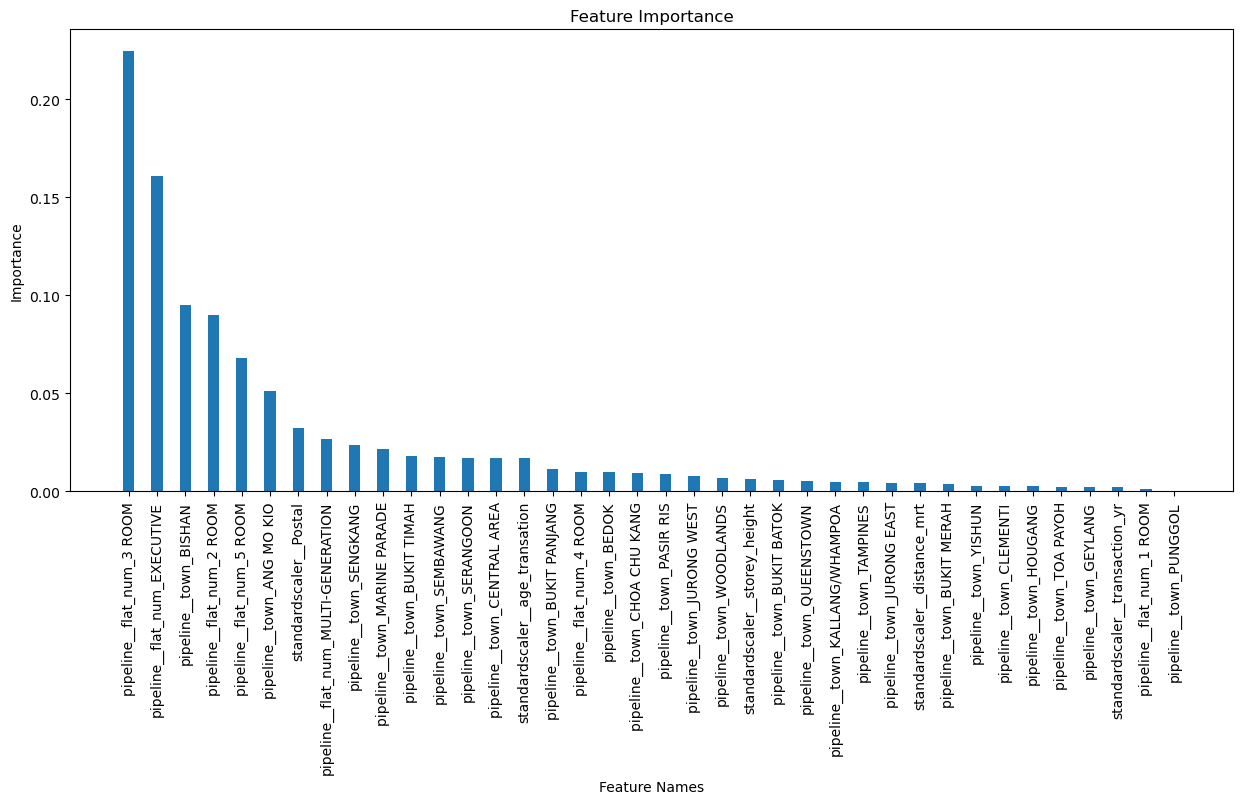

In [76]:
# Feature Importance

model = pipe_xgb_opt.named_steps['xgbregressor']
col_names = pipe_xgb_opt[:-1].get_feature_names_out()
feat_importance = model.feature_importances_

# Combine feature names and importances
features = list(zip(col_names, feat_importance))

# Sort features by importance (descending order)
features.sort(key=lambda x: x[1], reverse=True)

# Extract sorted feature names and importances
sorted_col_names, sorted_feat_importance = zip(*features)

plt.figure(figsize=(15, 6))
x = range(len(sorted_col_names))
plt.bar(sorted_col_names, sorted_feat_importance, width=0.4, align='center', label='Feature Importance')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(x, sorted_col_names, rotation=90)
plt.show()

Here, we can see that the features that are important are mostly categorical features. The most important seems to be the types of rooms, which makes sense as larger rooms fetch higher prices. The strongest numerical features are age of transaction, distance to mrt, and storey height. 

In [77]:
# save the xgb model to disk
import pickle
filename = 'model/finalized_model.sav'
pickle.dump(pipe_xgb_opt, open(filename, 'wb'))

In [78]:
# To test if this saved model works

import pickle
import os

filename = 'model/finalized_model.sav'

# saving/loading data
if os.path.exists("./model/finalized_model.sav"):
    model = pickle.load(open(filename, 'rb'))
    print('loaded model')
else:
    pickle.dump(model, open(filename, 'wb'))

loaded model


In [79]:
#extract feature names#
feature_names = model[:-1].get_feature_names_out()
model.score(X_test, y_test)

0.9589154067873966

In [80]:
model.predict(X_test.iloc[[622]])

array([365896.16], dtype=float32)

In [81]:
y_test.iloc[622]

345942.2492401216